In [3]:
!mkdir -p /content/paderborn_local
!unzip -q "/content/drive/MyDrive/Padeborn_Dataset/padeborn.zip" -d /content/paderborn_local

In [4]:
dataset_path = "/content/paderborn_local"

In [5]:
import os
import numpy as np
import scipy.io
import pandas as pd
import random

def build_raw_balanced_dataset(base_path, samples_per_class=5000, segment_size=1024):
    data_by_label = {0: [], 1: [], 2: [], 3: []}
    file_list = []

    for root, _, files in os.walk(base_path):
        for f in files:
            if f.endswith(".mat"):
                file_list.append(os.path.join(root, f))

    random.shuffle(file_list)

    for f_path in file_list:
        f = os.path.basename(f_path)
        label = -1
        if "K00" in f: label = 0
        elif "KA" in f: label = 1
        elif "KI" in f: label = 2
        elif "KB" in f: label = 3

        if label == -1 or len(data_by_label[label]) >= samples_per_class:
            continue

        try:
            mat = scipy.io.loadmat(f_path)
            key = [k for k in mat.keys() if not k.startswith('_')][0]

            vibration = mat[key][0, 0]['Y'][0, 6]['Data'].flatten()


            for i in range(0, len(vibration) - segment_size, segment_size):
                if len(data_by_label[label]) < samples_per_class:
                    seg = vibration[i : i + segment_size]

                    data_by_label[label].append(np.append(seg, label))
                else:
                    break
        except:
            continue

    final_data = []
    for lbl in data_by_label:
        final_data.extend(data_by_label[lbl])


    cols = [f'p{i}' for i in range(segment_size)] + ['label']
    return pd.DataFrame(final_data, columns=cols)


df_raw = build_raw_balanced_dataset(dataset_path)
df_raw.to_csv('/content/drive/MyDrive/Padeborn_Dataset/train_cnn_quantum.csv', index=False)

KeyboardInterrupt: 

In [2]:
!pip install pennylane torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 129.9 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np


n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):

    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class CNNQuantumModel(nn.Module):
    def __init__(self, n_layers=4):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=64, stride=8),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=16, stride=4),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )


        self.fc_compress = nn.Linear(32, n_qubits)

        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        #
        self.fc_final = nn.Linear(n_qubits, 4)

    def forward(self, x):

        x = self.cnn(x)
        x = x.view(-1, 32)
        x = self.fc_compress(x)


        x = torch.tanh(x) * (np.pi / 2) + (np.pi / 2)

        x = self.quantum_layer(x)
        return torch.log_softmax(self.fc_final(x), dim=1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNQuantumModel(n_layers=4).to(device)

print(f"Modelo pronto para rodar em: {device}")

Modelo pronto para rodar em: cuda


In [7]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


df = pd.read_csv('/content/drive/MyDrive/Padeborn_Dataset/train_cnn_quantum.csv')

X = df.drop('label', axis=1).values
y = df['label'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


X_train_t = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 1024)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 1024)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=32, shuffle=False)

In [8]:
import torch.optim as optim
from tqdm import tqdm


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

def train_cnn_quantum(model, train_loader, test_loader, epochs=15):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for signals, labels in pbar:
            signals, labels = signals.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{100 * correct / total:.2f}%"})


        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for signals, labels in test_loader:
                signals, labels = signals.to(device), labels.to(device)
                outputs = model(signals)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_acc = 100 * test_correct / test_total
        print(f"Final Epoch {epoch+1} - Test Acc: {test_acc:.2f}% | Avg Loss: {running_loss/len(train_loader):.4f}")


        scheduler.step(test_acc)


train_cnn_quantum(model, train_loader, test_loader, epochs=15)

Epoch 1/15: 100%|██████████| 500/500 [00:39<00:00, 12.53it/s, loss=0.8651, acc=52.19%]


Final Epoch 1 - Test Acc: 72.30% | Avg Loss: 1.1657


Epoch 2/15: 100%|██████████| 500/500 [00:32<00:00, 15.32it/s, loss=0.7169, acc=71.14%]


Final Epoch 2 - Test Acc: 74.25% | Avg Loss: 0.8027


Epoch 3/15: 100%|██████████| 500/500 [00:32<00:00, 15.53it/s, loss=0.4825, acc=75.15%]


Final Epoch 3 - Test Acc: 81.40% | Avg Loss: 0.6589


Epoch 4/15: 100%|██████████| 500/500 [00:32<00:00, 15.21it/s, loss=0.3349, acc=77.72%]


Final Epoch 4 - Test Acc: 81.53% | Avg Loss: 0.5862


Epoch 5/15: 100%|██████████| 500/500 [00:33<00:00, 15.09it/s, loss=0.3213, acc=80.24%]


Final Epoch 5 - Test Acc: 83.12% | Avg Loss: 0.5342


Epoch 6/15: 100%|██████████| 500/500 [00:31<00:00, 15.71it/s, loss=0.4348, acc=81.06%]


Final Epoch 6 - Test Acc: 83.17% | Avg Loss: 0.5012


Epoch 7/15: 100%|██████████| 500/500 [00:31<00:00, 15.77it/s, loss=0.5803, acc=81.77%]


Final Epoch 7 - Test Acc: 84.33% | Avg Loss: 0.4793


Epoch 8/15: 100%|██████████| 500/500 [00:31<00:00, 15.67it/s, loss=0.4439, acc=82.59%]


Final Epoch 8 - Test Acc: 80.33% | Avg Loss: 0.4505


Epoch 9/15: 100%|██████████| 500/500 [00:31<00:00, 15.97it/s, loss=0.2148, acc=83.28%]


Final Epoch 9 - Test Acc: 85.17% | Avg Loss: 0.4329


Epoch 10/15: 100%|██████████| 500/500 [00:31<00:00, 15.74it/s, loss=0.3125, acc=83.69%]


Final Epoch 10 - Test Acc: 86.15% | Avg Loss: 0.4171


Epoch 11/15: 100%|██████████| 500/500 [00:32<00:00, 15.20it/s, loss=0.4658, acc=84.16%]


Final Epoch 11 - Test Acc: 84.72% | Avg Loss: 0.4038


Epoch 12/15: 100%|██████████| 500/500 [00:31<00:00, 15.78it/s, loss=0.2761, acc=84.81%]


Final Epoch 12 - Test Acc: 86.22% | Avg Loss: 0.3884


Epoch 13/15: 100%|██████████| 500/500 [00:31<00:00, 15.84it/s, loss=0.4068, acc=84.99%]


Final Epoch 13 - Test Acc: 87.22% | Avg Loss: 0.3801


Epoch 14/15: 100%|██████████| 500/500 [00:32<00:00, 15.29it/s, loss=0.3481, acc=85.97%]


Final Epoch 14 - Test Acc: 86.30% | Avg Loss: 0.3620


Epoch 15/15: 100%|██████████| 500/500 [00:32<00:00, 15.39it/s, loss=0.2490, acc=86.21%]


Final Epoch 15 - Test Acc: 86.90% | Avg Loss: 0.3537


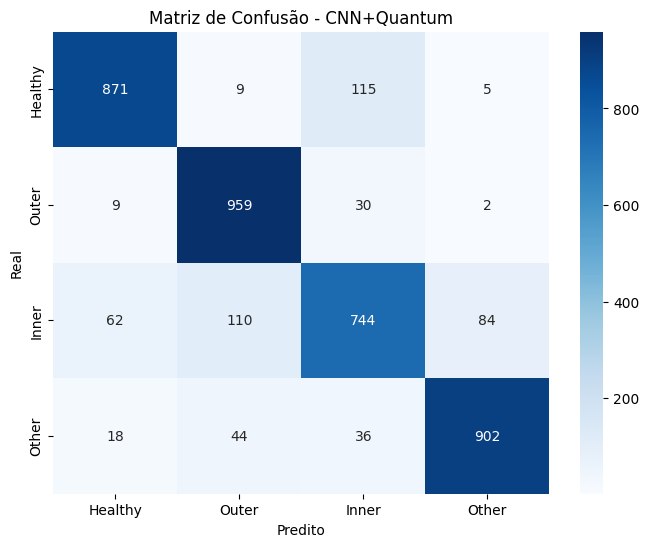


--- Relatório de Classificação ---
              precision    recall  f1-score   support

     Healthy       0.91      0.87      0.89      1000
       Outer       0.85      0.96      0.90      1000
       Inner       0.80      0.74      0.77      1000
       Other       0.91      0.90      0.91      1000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_results(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for signals, labels in test_loader:
            signals, labels = signals.to(device), labels.to(device)
            outputs = model(signals)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Matriz de Confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Healthy', 'Outer', 'Inner', 'Other'],
                yticklabels=['Healthy', 'Outer', 'Inner', 'Other'])
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão - CNN+Quantum')
    plt.show()


    print("\n--- Relatório de Classificação ---")
    print(classification_report(y_true, y_pred, target_names=['Healthy', 'Outer', 'Inner', 'Other']))


plot_results(model, test_loader)

In [13]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
from tqdm import tqdm
import torch.optim as optim


n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)


@qml.qnode(dev, interface="torch")
def quantum_circuit_reupload(inputs, weights):
    for i in range(weights.shape[0]):
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights[i:i+1], wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


class CNNQuantumV4(nn.Module):
    def __init__(self, n_layers=6):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=64, stride=4),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=16, stride=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1) # Sai com [Batch, 32, 1]
        )


        self.fc_compress = nn.Linear(32, 4)

        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit_reupload, weight_shapes)

        self.fc_final = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 4)
        )

    def forward(self, x):

        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc_compress(x)


        x = torch.tanh(x) * (np.pi / 2) + (np.pi / 2)

        x = self.quantum_layer(x)
        x = self.fc_final(x)
        return torch.log_softmax(x, dim=1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v4 = CNNQuantumV4(n_layers=6).to(device)

optimizer = optim.Adam(model_v4.parameters(), lr=0.0005)
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

print(f"Modelo V4 Corrigido e Otimizador prontos em: {device}")

Modelo V4 Corrigido e Otimizador prontos em: cuda


In [14]:
train_cnn_quantum(model_v4, train_loader, test_loader, epochs=20)

Epoch 1/20: 100%|██████████| 500/500 [01:02<00:00,  7.96it/s, loss=0.8981, acc=52.19%]


Final Epoch 1 - Test Acc: 63.65% | Avg Loss: 1.1754


Epoch 2/20: 100%|██████████| 500/500 [00:59<00:00,  8.43it/s, loss=0.8437, acc=64.67%]


Final Epoch 2 - Test Acc: 66.65% | Avg Loss: 0.8230


Epoch 3/20: 100%|██████████| 500/500 [01:01<00:00,  8.15it/s, loss=0.4517, acc=66.87%]


Final Epoch 3 - Test Acc: 65.83% | Avg Loss: 0.7171


Epoch 4/20: 100%|██████████| 500/500 [00:58<00:00,  8.49it/s, loss=0.6970, acc=70.33%]


Final Epoch 4 - Test Acc: 73.42% | Avg Loss: 0.6578


Epoch 5/20: 100%|██████████| 500/500 [00:58<00:00,  8.52it/s, loss=0.5308, acc=73.94%]


Final Epoch 5 - Test Acc: 77.92% | Avg Loss: 0.6111


Epoch 6/20: 100%|██████████| 500/500 [00:59<00:00,  8.45it/s, loss=0.7989, acc=77.18%]


Final Epoch 6 - Test Acc: 78.35% | Avg Loss: 0.5593


Epoch 7/20: 100%|██████████| 500/500 [00:58<00:00,  8.51it/s, loss=0.3444, acc=80.15%]


Final Epoch 7 - Test Acc: 78.17% | Avg Loss: 0.4996


Epoch 8/20: 100%|██████████| 500/500 [00:58<00:00,  8.60it/s, loss=0.4912, acc=81.89%]


Final Epoch 8 - Test Acc: 84.67% | Avg Loss: 0.4535


Epoch 9/20: 100%|██████████| 500/500 [00:57<00:00,  8.64it/s, loss=0.2862, acc=82.46%]


Final Epoch 9 - Test Acc: 83.50% | Avg Loss: 0.4342


Epoch 10/20: 100%|██████████| 500/500 [00:58<00:00,  8.58it/s, loss=0.4532, acc=83.29%]


Final Epoch 10 - Test Acc: 86.33% | Avg Loss: 0.4126


Epoch 11/20: 100%|██████████| 500/500 [00:58<00:00,  8.62it/s, loss=0.3335, acc=84.39%]


Final Epoch 11 - Test Acc: 85.78% | Avg Loss: 0.3899


Epoch 12/20: 100%|██████████| 500/500 [00:58<00:00,  8.62it/s, loss=0.6266, acc=84.42%]


Final Epoch 12 - Test Acc: 83.40% | Avg Loss: 0.3744


Epoch 13/20: 100%|██████████| 500/500 [00:59<00:00,  8.47it/s, loss=0.5049, acc=84.99%]


Final Epoch 13 - Test Acc: 88.17% | Avg Loss: 0.3644


Epoch 14/20: 100%|██████████| 500/500 [00:59<00:00,  8.46it/s, loss=0.7728, acc=85.75%]


Final Epoch 14 - Test Acc: 86.38% | Avg Loss: 0.3562


Epoch 15/20: 100%|██████████| 500/500 [00:59<00:00,  8.45it/s, loss=0.2304, acc=86.64%]


Final Epoch 15 - Test Acc: 86.22% | Avg Loss: 0.3269


Epoch 16/20: 100%|██████████| 500/500 [00:58<00:00,  8.52it/s, loss=0.2517, acc=86.31%]


Final Epoch 16 - Test Acc: 89.80% | Avg Loss: 0.3231


Epoch 17/20: 100%|██████████| 500/500 [00:58<00:00,  8.56it/s, loss=0.1603, acc=86.98%]


Final Epoch 17 - Test Acc: 89.85% | Avg Loss: 0.3196


Epoch 18/20: 100%|██████████| 500/500 [00:57<00:00,  8.65it/s, loss=0.3004, acc=87.94%]


Final Epoch 18 - Test Acc: 87.88% | Avg Loss: 0.3005


Epoch 19/20: 100%|██████████| 500/500 [00:57<00:00,  8.67it/s, loss=0.2336, acc=88.06%]


Final Epoch 19 - Test Acc: 89.35% | Avg Loss: 0.2958


Epoch 20/20: 100%|██████████| 500/500 [00:57<00:00,  8.64it/s, loss=0.1327, acc=88.54%]


Final Epoch 20 - Test Acc: 90.70% | Avg Loss: 0.2828


In [16]:
import torch


save_path = '/content/drive/MyDrive/Padeborn_Dataset/cnn_quantum_v4_90percent.pth'


torch.save({
    'epoch': 20,
    'model_state_dict': model_v4.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_acc': 90.70,
    'loss': 0.2828
}, save_path)

print(f"Modelo salvo com sucesso em: {save_path}")

Modelo salvo com sucesso em: /content/drive/MyDrive/Padeborn_Dataset/cnn_quantum_v4_90percent.pth


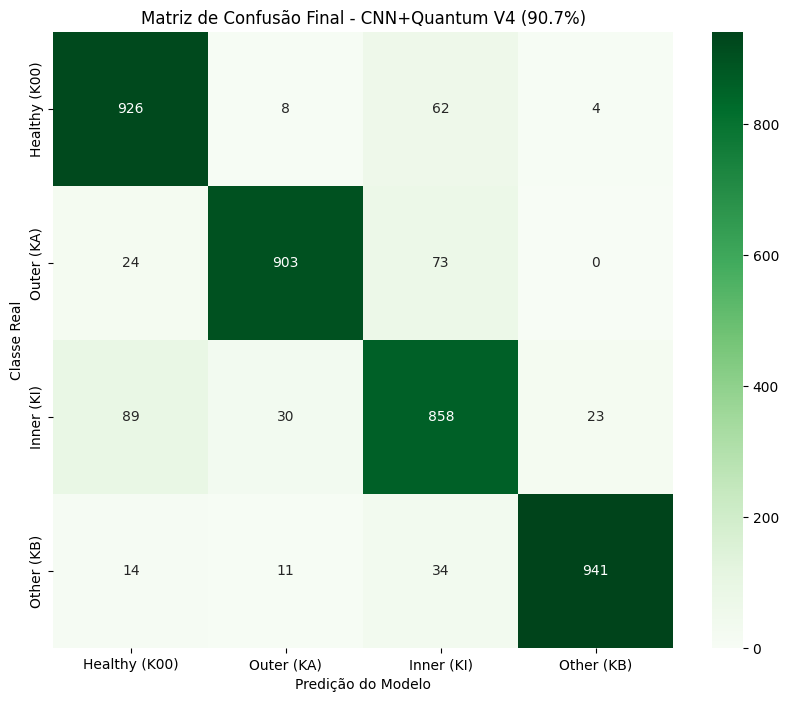


RELATÓRIO DE CLASSIFICAÇÃO FINAL - MODELO HÍBRIDO
               precision    recall  f1-score   support

Healthy (K00)       0.88      0.93      0.90      1000
   Outer (KA)       0.95      0.90      0.93      1000
   Inner (KI)       0.84      0.86      0.85      1000
   Other (KB)       0.97      0.94      0.96      1000

     accuracy                           0.91      4000
    macro avg       0.91      0.91      0.91      4000
 weighted avg       0.91      0.91      0.91      4000



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def plot_final_results(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for signals, labels in test_loader:
            signals, labels = signals.to(device), labels.to(device)
            outputs = model(signals)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())


    class_names = ['Healthy (K00)', 'Outer (KA)', 'Inner (KI)', 'Other (KB)']


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predição do Modelo')
    plt.ylabel('Classe Real')
    plt.title('Matriz de Confusão Final - CNN+Quantum V4 (90.7%)')
    plt.show()


    print("\n" + "="*60)
    print("RELATÓRIO DE CLASSIFICAÇÃO FINAL - MODELO HÍBRIDO")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=class_names))


plot_final_results(model_v4, test_loader)

In [18]:
def diagnosticar_rolamento(sinal_bruto, model):
    """
    Recebe um array de 1024 pontos e retorna a classe predita.
    """
    model.eval()
    with torch.no_grad():

        tensor_input = torch.tensor(sinal_bruto, dtype=torch.float32).view(1, 1, 1024).to(device)

        output = model(tensor_input)
        probabilidade, predicao = torch.max(torch.exp(output), 1)

        classes = ['Saudável (K00)', 'Falha Externa (KA)', 'Falha Interna (KI)', 'Outros Danos (KB)']
        resultado = classes[predicao.item()]
        confianca = probabilidade.item() * 100

        print(f"--- Diagnóstico ---")
        print(f"Condição: {resultado}")
        print(f"Confiança: {confianca:.2f}%")
        return resultado, confianca


amostra = X_test[0]
diagnosticar_rolamento(amostra, model_v4)

--- Diagnóstico ---
Condição: Outros Danos (KB)
Confiança: 99.92%


('Outros Danos (KB)', 99.92112517356873)

In [19]:
def testar_arquivo_novo(caminho_mat, model):

    mat = scipy.io.loadmat(caminho_mat)
    key = [k for k in mat.keys() if not k.startswith('_')][0]


    vibration = mat[key][0, 0]['Y'][0, 6]['Data'].flatten()


    start = np.random.randint(0, len(vibration) - 1024)
    segmento = vibration[start : start + 1024]

    print(f"Analisando arquivo: {os.path.basename(caminho_mat)}")
    return diagnosticar_rolamento(segmento, model)



In [25]:
testar_arquivo_novo('/content/paderborn_local/KA01/N09_M07_F10_KA01_1.mat', model_v4)

Analisando arquivo: N09_M07_F10_KA01_1.mat
--- Diagnóstico ---
Condição: Falha Externa (KA)
Confiança: 98.47%


('Falha Externa (KA)', 98.47249984741211)